In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [2]:
df = pd.read_csv('../data/preprocessed_data.csv')

In [3]:
df.head()

,Winner,title_bout,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,...,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Sideways,R_Stance_Southpaw,R_Stance_Switch
0,Red,False,0.000000,0.0,0.420000,0.49500,0.330,0.36000,0.500000,1.000000,...,0,1,0,0,0,0,1,0,0,0
1,Red,False,0.500000,0.0,0.660000,0.30500,0.300,0.50000,1.500000,0.000000,...,0,1,0,0,0,0,1,0,0,0
2,Red,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,1,0,0,0,0,0,0,1,0
3,Blue,False,0.015625,0.0,0.450000,0.42750,0.250,0.20000,0.148468,0.098389,...,0,0,0,1,0,0,0,0,0,1
4,Blue,False,0.125000,0.0,0.535625,0.57875,0.185,0.16625,0.125000,0.187500,...,0,1,0,0,0,0,1,0,0,0


### Normalizing data

In [4]:
df_num = df.select_dtypes(include=[np.float, np.int])

In [5]:
scaler = StandardScaler()

df[list(df_num.columns)] = scaler.fit_transform(df[list(df_num.columns)])

In [6]:
with open('../data/standard.scaler', 'wb') as f:
    pickle.dump(scaler, f)

### Making target variable balanced

In [7]:
df['Winner'].value_counts()

Red     3979
Blue    1923
Name: Winner, dtype: int64

In [8]:
3515 - ((3515+1617)/2)

949.0

In [9]:
sample = df[df['Winner']=='Red'].sample(n=949)
df.drop(sample.index, inplace=True)

In [10]:
rename_cols = {}
for column in sample.columns:
    if column.startswith('B_'):
        rename_cols['B_' + column.split('B_', 1)[1]] = 'R_' + column.split('B_', 1)[1]
        rename_cols['R_' + column.split('B_', 1)[1]] = 'B_' + column.split('B_', 1)[1]

sample.rename(rename_cols, axis='columns', inplace=True)
sample.replace({'Winner': 'Red'}, 'Blue', inplace=True)

In [11]:
df = pd.concat([df, sample]).sort_index()

### Shuffling data

In [12]:
sample1 = df[df['Winner']=='Red'].sample(n=1283)
sample2 = df[df['Winner']=='Blue'].sample(n=1283)

df.drop(sample1.index, inplace=True)
df.drop(sample2.index, inplace=True)

In [13]:
rename_cols = {}
for column in sample.columns:
    if column.startswith('B_'):
        rename_cols['B_' + column.split('B_', 1)[1]] = 'R_' + column.split('B_', 1)[1]
        rename_cols['R_' + column.split('B_', 1)[1]] = 'B_' + column.split('B_', 1)[1]

sample1.rename(rename_cols, axis='columns', inplace=True)
sample2.rename(rename_cols, axis='columns', inplace=True)

In [14]:
sample1.replace({'Winner': 'Red'}, 'Blue', inplace=True)
sample2.replace({'Winner': 'Blue'}, 'Red', inplace=True)

In [15]:
df = pd.concat([df, sample1, sample2]).sort_index()

### Splitting into train, test

In [16]:
y = df['Winner']
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)
# y_test = label_encoder.transform(Test['Winner'])

X = df.drop(columns='Winner')
# X_test = Test.drop(columns='Winner')
# X_test = X_test[X.columns]

X_train, X_valid, y_train, y_valid = train_test_split(X, label_encoded_y, test_size=0.1, random_state=41)

### Fitting baseline Xgboost

In [17]:
def plot_confusion(cm, classes):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    # Loop over data dimensions and create text annotations.
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [18]:
def modelfit(alg, X_train, y_train, X_valid, y_valid, X_test=None, y_test=None,
             useTrainCV=False, test_set=False, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(f"Best number of estimators = {cvresult.shape[0]}")
    
    #Fit the algorithm on the data
    alg.fit(np.array(X_train), np.array(y_train), eval_metric='auc')
    
    #Predict train set:
    dtrain_predictions = alg.predict(np.array(X_train))
    dtrain_predprob = alg.predict_proba(np.array(X_train))[:,1]
        
    #Predict valid set:
    dvalid_predictions = alg.predict(np.array(X_valid))
    dvalid_predprob = alg.predict_proba(np.array(X_valid))[:,1]
    
    #Predict test set:
    dtest_predictions = None
    if test_set:
        dtest_predictions = alg.predict(np.array(X_test))
        dtest_predprob = alg.predict_proba(np.array(X_test))[:,1]
        
    #Print model report:
    print("\nModel Report: ")
    if useTrainCV:
        print(f"AUC Score (Train): {roc_auc_score(y_train, dtrain_predprob)}")
    print(f"Accuracy (valid): {accuracy_score(y_valid, dvalid_predictions):.4f}")
    print(f"AUC Score (valid): {roc_auc_score(y_valid, dvalid_predprob):.4f}")
    if test_set:
        print(f"Accuracy (Test): {accuracy_score(y_test, dtest_predictions):.4f}")
        print(f"AUC Score (Test): {roc_auc_score(y_test, dtest_predprob):.4f}")
    
    
    return dvalid_predictions, dtest_predictions


Model Report: 
Accuracy (valid): 0.6904
AUC Score (valid): 0.7508


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

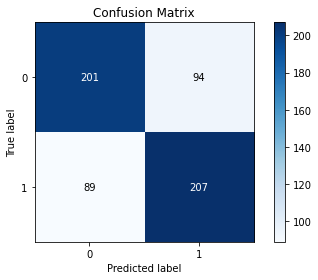

In [19]:
model1 = XGBClassifier(random_state=43, n_jobs=-1)

y1_valid_preds, y1_test_preds = modelfit(model1, X_train, y_train, X_valid, y_valid)

cm_valid = confusion_matrix(y_valid, y1_valid_preds)
# cm_test = confusion_matrix(y_test, y1_test_preds)
classes = unique_labels(y_valid, y1_valid_preds)

plot_confusion(cm_valid, classes)

In [20]:
feat_imps = {}
for i, imp in enumerate(model1.feature_importances_):
    feat_imps[X_train.columns[i]] = imp

sorted_imp_feats = (sorted(feat_imps.items(), key = lambda x: x[1], reverse=True))
sorted_imp_feats

[('R_Stance_Sideways', 0.44911972),
 ('B_Stance_Sideways', 0.23029105),
 ('R_Stance_Open Stance', 0.021247476),
 ('R_win_by_Decision_Split', 0.014716374),
 ('weight_class_WomenBantamweight', 0.006160083),
 ('weight_class_Featherweight', 0.0051968284),
 ('R_avg_opp_DISTANCE_landed', 0.0036314942),
 ('R_avg_opp_HEAD_landed', 0.0030312405),
 ('B_avg_opp_BODY_att', 0.003018484),
 ('B_age', 0.0029906249),
 ('R_current_win_streak', 0.0029140632),
 ('R_avg_TD_landed', 0.0029059728),
 ('R_total_title_bouts', 0.0028427492),
 ('B_avg_DISTANCE_landed', 0.0028068009),
 ('B_avg_SIG_STR_att', 0.0027899633),
 ('R_avg_opp_SIG_STR_landed', 0.0027859928),
 ('B_win_by_Decision_Unanimous', 0.0026963982),
 ('R_avg_GROUND_att', 0.002689718),
 ('B_win_by_Decision_Split', 0.0026361907),
 ('B_avg_TD_landed', 0.002619606),
 ('weight_class_Bantamweight', 0.0025814753),
 ('B_avg_opp_CTRL_time(seconds)', 0.0025766979),
 ('R_avg_DISTANCE_att', 0.0025753279),
 ('B_avg_opp_SIG_STR_att', 0.0025604614),
 ('R_avg_HEAD_l

### Hyperparameter tuning 


Model Report: 
Accuracy (valid): 0.7022
AUC Score (valid): 0.7734


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

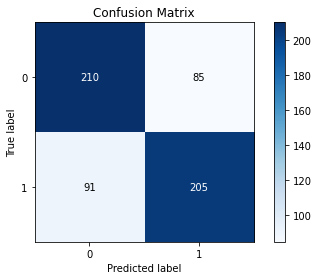

In [21]:
model3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4
#  scale_pos_weight=0.5,
)

y3_valid_preds, y3_test_preds = modelfit(model3, X_train, y_train, X_valid, y_valid)

cm_valid = confusion_matrix(y_valid, y3_valid_preds)
# cm_test = confusion_matrix(y_test, y3_test_preds)
classes = unique_labels(y_valid, y3_valid_preds)

plot_confusion(cm_valid, classes)


Model Report: 
Accuracy (valid): 0.6836
AUC Score (valid): 0.7604


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

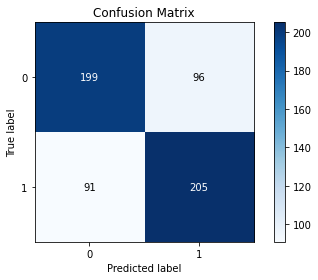

In [22]:
model5 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=120,
 max_depth=3,
 min_child_weight=1,
 gamma=0.3,
 subsample=1,
 colsample_bytree=1,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
)

y5_valid_preds, y5_test_preds = modelfit(model5, X_train, y_train, X_valid, y_valid)

cm_valid = confusion_matrix(y_valid, y5_valid_preds)
# cm_test = confusion_matrix(y_test, y5_test_preds)
classes = unique_labels(y_valid, y5_valid_preds)

plot_confusion(cm_valid, classes)

In [23]:
print(classification_report(y_valid, y1_valid_preds))

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       295
           1       0.69      0.70      0.69       296

    accuracy                           0.69       591
   macro avg       0.69      0.69      0.69       591
weighted avg       0.69      0.69      0.69       591



In [24]:
print(classification_report(y_valid, y3_valid_preds))

              precision    recall  f1-score   support

           0       0.70      0.71      0.70       295
           1       0.71      0.69      0.70       296

    accuracy                           0.70       591
   macro avg       0.70      0.70      0.70       591
weighted avg       0.70      0.70      0.70       591



In [25]:
print(classification_report(y_valid, y5_valid_preds))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       295
           1       0.68      0.69      0.69       296

    accuracy                           0.68       591
   macro avg       0.68      0.68      0.68       591
weighted avg       0.68      0.68      0.68       591



In [26]:
model = model3

model.fit(np.array(X), np.array(label_encoded_y))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method=None, validate_parameters=False,
              verbosity=None)

In [27]:
with open('../data/model.sav', 'wb') as f:
    pickle.dump(model, f)

In [28]:
with open('../data/model.sav', 'rb') as f:
    mdl = pickle.load(f)

In [29]:
mdl.predict(np.array(X[:40]))

array([1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])